# VPN User Usage Analytics

In this notebook we are getting data from our mongodb.

Data that saved in mongodb is by the script named `get_data` that runs every 1 hour.

In [1]:
from pymongo import MongoClient as mongo # Database
from matplotlib import pyplot as plt # Matplotlib
import pandas as pd # Pandas
import numpy as np # Numpy
import requests as req # Make HTTP requests
import seaborn as sb # Color
import squarify # Treemap
import datetime # Date and time

# Config
from config.config import env

## Get data

Find data from **API** and find from **Database**.

In [2]:
# Create mongo connection
client = mongo(env('MONGO_ATLAS'))

db = client["vpn"] # Use database
collection = db['stats'] # Use collection

In [3]:
# The base URL
base_url = "http://95.216.138.218:2003"

# Add headers to authorize in API
headers = {
    "Cookie": env('COOCIE')
}

# Get list of 
list = req.post(f"{base_url}/xui/inbound/list", headers=headers, data={})

# Make json and get only `obj` item
data = list.json()["obj"][:-1]

combined = [item["down"] + item["up"] for item in data]

for i in range(0, len(data)):
    total = data[i]["down"] + data[i]["up"]
    
    gb = round(total/(1024*1024*1024), 2)
    
    data[i]['combined'] = gb

## Clean data

Make a clean data from saved data on **MongoDB**.

In [4]:
# Find records
d = collection.find({'id': {'$ne': 20}})

categorized_data = []

for record in d:
    name = record['remark']
    id = record['id']
    doc = {'id': record['id'], 'remark': record['remark'], 'sequence': record['sequence'], 'download': record['download'], 'upload': record['upload']}
    
    # Check if a category with the same name and id already exists in the categorized data
    category_exists = False
    for category in categorized_data:
        if category['remark'] == name and category['id'] == id:
            category['docs'].append(doc)
            category_exists = True
            break
    
    # If a category with the same name and id doesn't exist, create a new category
    if not category_exists:
        category = {'remark': name, 'id': id, 'docs': [doc]}
        categorized_data.append(category)

## Line chart

Create line chart.

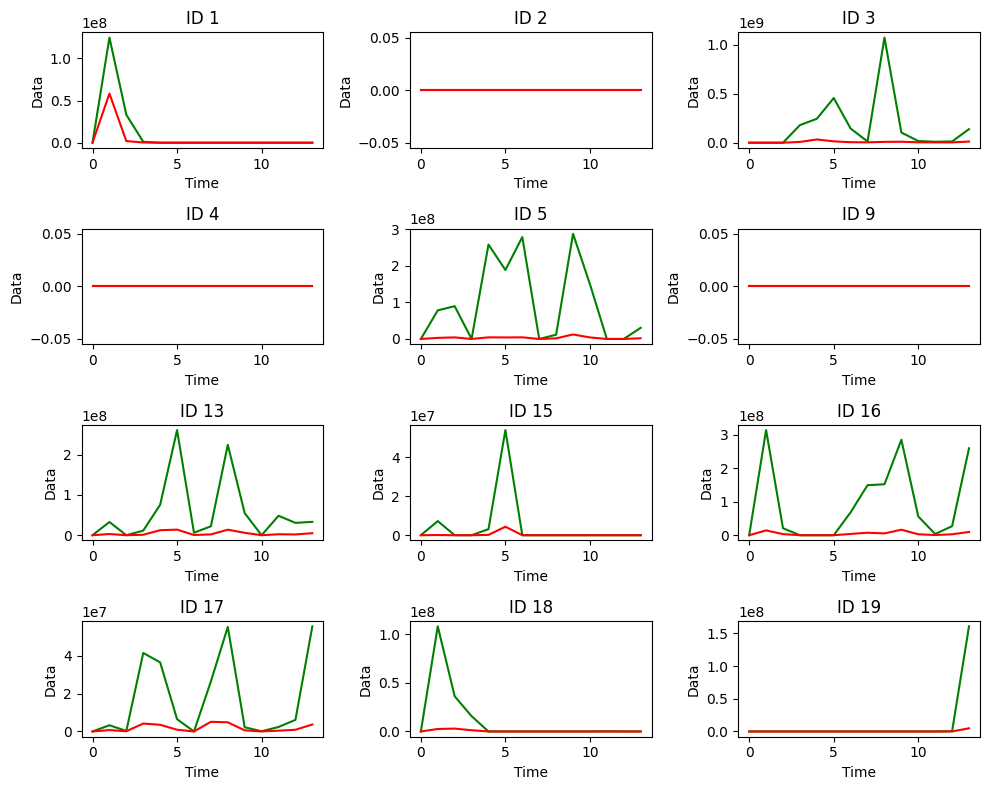

In [5]:
total_items = len(categorized_data)
num_rows = int(total_items ** 0.5) + 1
num_cols = int(total_items ** 0.5) if total_items % int(total_items ** 0.5) == 0 else int(total_items ** 0.5) + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for i, category in enumerate(categorized_data):
    ax = axes[i // num_cols, i % num_cols]
    
    docs = category['docs']
    
    df = pd.DataFrame(docs)

    df['upload'] = df['upload'].diff().fillna(0)
    df['download'] = df['download'].diff().fillna(0)
    
    sequences = [datetime.datetime.fromtimestamp(item).strftime("%m/%d %H") for item in df.sequence]
    seqs = [x for x, item in enumerate(df.sequence)]
    
    ax.plot(seqs, df.download, color='green', label='Download')
    ax.plot(seqs, df.upload, color='red', label='Upload')
    
    ax.set_title(f"ID {category['id']}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Data')

plt.tight_layout()
plt.show()

## Pie chart

Pie plot with uploads and downloads data.

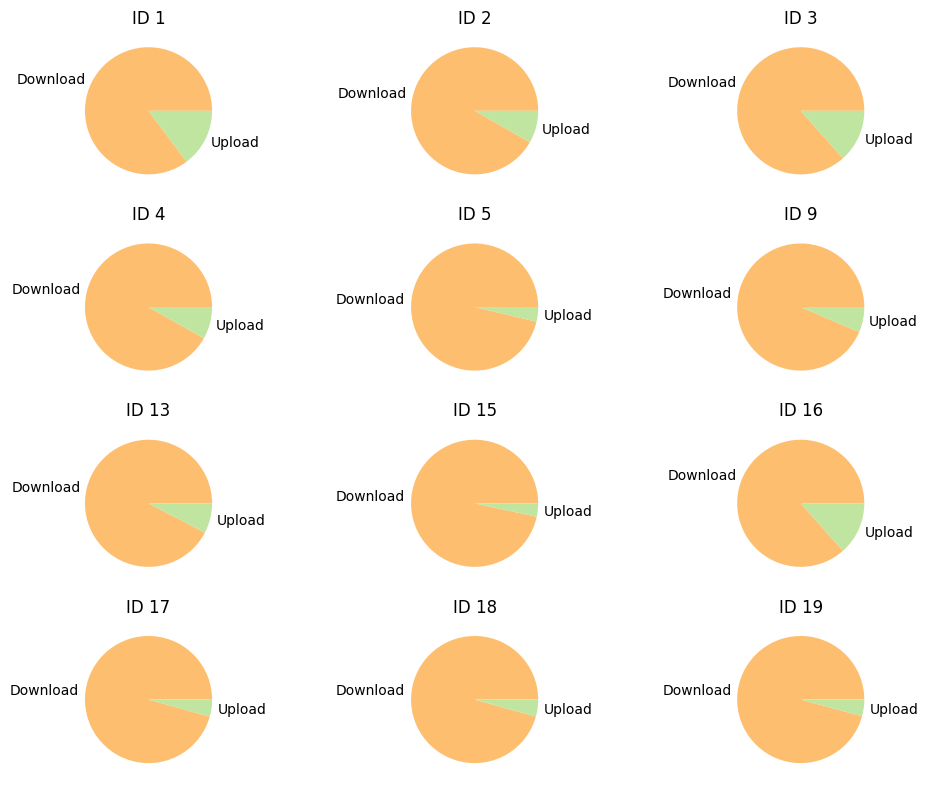

In [6]:
total_items = len(data)
num_rows = int(total_items ** 0.5) + 1
num_cols = int(total_items ** 0.5) if total_items % int(total_items ** 0.5) == 0 else int(total_items ** 0.5) + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for i, user in enumerate(data):
    ax = axes[i // num_cols, i % num_cols]
        
    pie_sized = [user['down'], user['up']]
    pie_label = ['Download', 'Upload']
    
    ax.pie(
        pie_sized,
        labels=pie_label,
        colors=sb.color_palette("Spectral", len(pie_sized)),
        shadow=False
    )

    ax.set_title(f"ID {user['id']}")

plt.tight_layout()
plt.show()

## Treemap

Here we can only get treemap of usages.

Example: [tsetmc.com](http://main.tsetmc.com/marketmap)

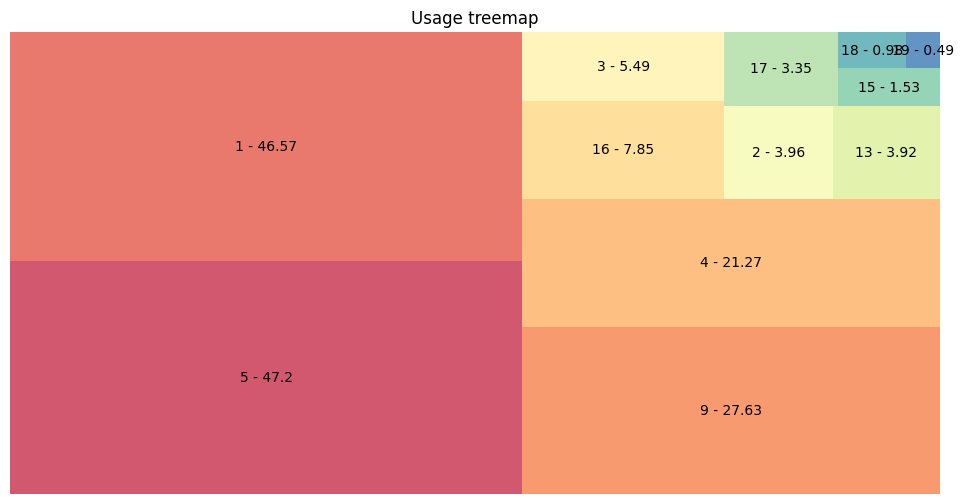

In [7]:
df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

sorted_data = sorted(data, key=lambda x: x['combined'], reverse=True)
total = sum(item['combined'] for item in sorted_data)

cmap = sb.color_palette("Spectral_r", len(sorted_data))[::-1]

# Make treemap
squarify.plot(
    sizes=[item['combined'] for item in sorted_data],
    label=[f'{item["id"]} - {item["combined"]}' for item in sorted_data], # Add labels
    color=cmap, # Add color
    alpha=0.8
)

# Customize and show
plt.title("Usage treemap") # Title
plt.axis("off") # Disable border stuf
plt.show() # Show the plot